<a href="https://colab.research.google.com/github/ravindrabharathi/LSTM/blob/master/Text-Gen-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Generation using LSTM 

We will use a RNN-LSTM model to generate text . The data that we will use is Lewis Carroll's Alice in Wonderland from Gutenberg online library


### import required modules 

In [0]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import nltk.data
import string



Using TensorFlow backend.


### import nltk to process and analyse the text data 

In [0]:
nltk.download('gutenberg')
nltk.download('punkt')
from nltk.text import Text


[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### download the alice in wonderland text from gutenberg corpus of nltk and  check the sentence lengths 

In [0]:
from nltk.corpus import gutenberg 
alice = gutenberg.sents('carroll-alice.txt')
sents_list = [" ".join(sent) for sent in alice]
mx_ln=0
mn_ln=100
for sent in sents_list:
  if (len(sent)>mx_ln):
    mx_ln=len(sent)
  if (len(sent)<mn_ln):
    mn_ln=len(sent)
print('number of sentences =%d'%len(sents_list))
print('max sentence length = %d'%mx_ln) 
print('min sentence length = %d'%mn_ln)

number of sentences =1703
max sentence length = 944
min sentence length = 4


### there is a wide variation in sentence lengths . So instead of splitting by sentences , let us split the data by lines and use it to generate text 

### get the text as a single file 



In [0]:
!wget 'https://raw.githubusercontent.com/srbharathee/DL/master/lewis_carrol.txt'

--2019-07-26 05:27:22--  https://raw.githubusercontent.com/srbharathee/DL/master/lewis_carrol.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144431 (141K) [text/plain]
Saving to: ‘lewis_carrol.txt’

lewis_carrol.txt    100%[===================>] 141.05K  --.-KB/s    in 0.04s   

2019-07-26 05:27:22 (3.75 MB/s) - ‘lewis_carrol.txt’ saved [144431/144431]



### print out the head portion to check downloaded file is in order 

In [0]:
!head -20 'lewis_carrol.txt'

ALICE'S ADVENTURES IN WONDERLAND

Lewis Carroll

THE MILLENNIUM FULCRUM EDITION 3.0




CHAPTER I. Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into the
book her sister was reading, but it had no pictures or conversations in
it, 'and what is the use of a book,' thought Alice 'without pictures or
conversations?'

So she was considering in her own mind (as well as she could, for the
hot day made her feel very sleepy and stupid), whether the pleasure
of making a daisy-chain would be worth the trouble of getting up and


### read lines from the file 

In [0]:
with open('lewis_carrol.txt', 'r') as f:
  lines=f.readlines()
  


### print some stats for the set of lines 

In [0]:
print("number of lines = %d"%(len(lines)))  
clean_up=[]
max_l=0
for line in lines:
  
  if (len(line)<5):
    clean_up.append(line)
  if (len(line)>max_l):
    max_l=len(line)
  if (len(line)>500):
    print("large  "+str(len(line)))
print("number of lines with length <5 = %d"%len(clean_up))    
print("max length = %d "%max_l)


number of lines = 3339
number of lines with length <5 = 858
max length = 75 


### clean up the data , remove return and new line chars , remove punctuation 

 cleaned lines = 2412 
 small lines(len <40)  =537 
 medium lines(len <60) = 328 
 large lines(len >=60) = 1547 
 max line length =73




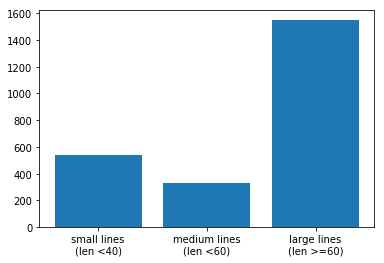

In [0]:
large_lines=[]
medium_lines=[]
small_lines=[]
max_l=0
cleaned_lines=[]

for line in lines:
  #strip return and new line characters 
  line=line.strip('\r\n')
  
  
  if (len(line)>10 ):
    #remove punctuations 
    line=line.translate(str.maketrans('', '', string.punctuation))
    #convert all chars to lowercase 
    line=line.lower()
    cleaned_lines.append(line)
    if (len(line)<40):
      #print(line)
      small_lines.append(line)
    elif (len(line)<60):
      medium_lines.append(line)
    else:
      large_lines.append(line)
  if (len(line)>max_l):
    max_l=len(line)   
print(' cleaned lines = %d \n small lines(len <40)  =%d \n medium lines(len <60) = %d \n large lines(len >=60) = %d \n max line length =%d\n\n' %(len(cleaned_lines), len(small_lines),len(medium_lines),len(large_lines), max_l))  

import matplotlib.pyplot as plt
import numpy as np

line_size=[len(small_lines),len(medium_lines),len(large_lines)]
line_cat=['small lines\n(len <40)','medium lines\n(len <60)','large lines\n(len >=60)']
y_pos = np.arange(len(line_cat))
plt.bar(y_pos, line_size)
plt.xticks(y_pos, line_cat)

plt.show()



### here we see that the variation is lengths is lesser compared to splitting by sentences 

### create our raw data and character dictionary of char to integer mapping . This will be our vocabulary 

In [0]:
raw_text=[]
for line in cleaned_lines:
  for char1 in line:
    raw_text.append(char1)
print(len(raw_text))
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)
print(chars)

132379
Total Characters:  132379
Total Vocab:  29
[' ', '0', '3', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### use a max length of 73 and pad the lines that are of smaller size

In [0]:
#pad the sentences based on the max length of lines that we found earlier
from keras.preprocessing.sequence import pad_sequences
dataX1=[]
for line in cleaned_lines:
  line=[char_to_int[char] for char in line]
  dataX1.append(line)
dataX1=pad_sequences(dataX1,maxlen=max_l,padding='pre')

### form the dataset to be used for training

In [0]:
dataX=[]
dataY=[]
seq_length = max_l

'''
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
	seq_in = raw_text[i:i + seq_length]
	seq_out = raw_text[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print( "Total Patterns: ", n_patterns)
'''

raw_text=[]
for line in dataX1:
  raw_text.extend(line)
for i in range(0,len(raw_text)-seq_length):
  seq_in = raw_text[i:i + seq_length]
  seq_out = raw_text[i + seq_length]
  dataX.append([char for char in seq_in])
  dataY.append(seq_out)
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)  




Total Patterns:  176003


### the reshape training data / predictors and turn the ground truth labels to categorical one hot vectors 

In [0]:
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, max_l,1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [0]:
print(X.shape,y.shape)

(176003, 73, 1) (176003, 29)


### build our model . Use Keras functional API . Our model has a dropout of 0.1 for input , has two LSTM layers of size 256 , followed by a dense layer and softmax activation 

### compile the model using adam optimizer

In [0]:
# define the LSTM model , using functional API 
from keras.models import Model
from keras.layers import Embedding,Flatten
'''
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

'''

input_layer=Input(shape=(X.shape[1],X.shape[2] ))
x= Dropout(0.1)(input_layer)
#x=Embedding(n_vocab+1, 64, input_length=max_l,mask_zero=True)(x)

x= LSTM(256,return_sequences=True)(x)
x= Dropout(0.1)(x)
x=LSTM(256,return_sequences=True)(x)
x=Dropout(0.1)(x)
#x=LSTM(256,return_sequences=True)(x)
#x=Dropout(0.1)(x)
x=LSTM(256,return_sequences=False)(x)
x=Dense(y.shape[1])(x)

output=Activation('softmax')(x)

model=Model(input_layer,output)
model.compile(loss='categorical_crossentropy', optimizer='adam')


W0726 05:27:31.380825 140592439719808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 05:27:31.422128 140592439719808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 05:27:31.431694 140592439719808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0726 05:27:31.445803 140592439719808 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a futur

### print model summary 

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 73, 1)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 73, 256)           264192    
_________________________________________________________________
dropout_2 (Dropout)          (None, 73, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 73, 256)           525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 73, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
__________

### print X and y shape

In [0]:
print(X.shape,y.shape)

(176003, 73, 1) (176003, 29)


### mount Google drive in order to save the trained model 

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


### define a ModelCheckpoint callback to save the model during training 

In [0]:
# define the checkpoint
filepath="/gdrive/My Drive/EIP3/session6/best_model_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

### we will train the model for 100 epochs . Since LSTM /RNN takes a long time to train we will split the training into 5 sets of 20 epochs . We will use a batch size of 128 

In [0]:
model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)

W0725 05:04:59.135103 140331015251840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
176003/176003 [==============================] - 601s 3ms/step - loss: 2.1412

Epoch 00001: loss improved from inf to 2.14124, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 2/20
176003/176003 [==============================] - 593s 3ms/step - loss: 1.8466

Epoch 00002: loss improved from 2.14124 to 1.84664, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 3/20
176003/176003 [==============================] - 593s 3ms/step - loss: 1.7089

Epoch 00003: loss improved from 1.84664 to 1.70893, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 4/20
176003/176003 [==============================] - 598s 3ms/step - loss: 1.6206

Epoch 00004: loss improved from 1.70893 to 1.62064, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 5/20
176003/176003 [==============================] - 593s 3ms/step - loss: 1.5647

Epoch 00005: loss improved from 1.62064 to 1.56468, saving mod

### epoch 21-40 

In [0]:
model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)

Epoch 1/20
176003/176003 [==============================] - 594s 3ms/step - loss: 1.2074

Epoch 00001: loss improved from 1.21723 to 1.20743, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 2/20
176003/176003 [==============================] - 592s 3ms/step - loss: 1.1951

Epoch 00002: loss improved from 1.20743 to 1.19514, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 3/20
176003/176003 [==============================] - 589s 3ms/step - loss: 1.1865

Epoch 00003: loss improved from 1.19514 to 1.18647, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 4/20
176003/176003 [==============================] - 598s 3ms/step - loss: 1.1765

Epoch 00004: loss improved from 1.18647 to 1.17648, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 5/20
176003/176003 [==============================] - 594s 3ms/step - loss: 1.1662

Epoch 00005: loss improved from 1.17648 to 1.16622, saving

### epoch 41-60 

In [0]:
model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)

Epoch 1/20
176003/176003 [==============================] - 591s 3ms/step - loss: 1.0672

Epoch 00001: loss improved from 1.07302 to 1.06717, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 2/20
176003/176003 [==============================] - 595s 3ms/step - loss: 1.0667

Epoch 00002: loss improved from 1.06717 to 1.06672, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 3/20
176003/176003 [==============================] - 592s 3ms/step - loss: 1.0591

Epoch 00003: loss improved from 1.06672 to 1.05912, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 4/20
176003/176003 [==============================] - 592s 3ms/step - loss: 1.0540

Epoch 00004: loss improved from 1.05912 to 1.05397, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 5/20
176003/176003 [==============================] - 596s 3ms/step - loss: 1.0443

Epoch 00005: loss improved from 1.05397 to 1.04428, saving

### epoch 61-80

In [0]:
model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)

Epoch 1/20
176003/176003 [==============================] - 595s 3ms/step - loss: 0.9883

Epoch 00001: loss improved from 0.98911 to 0.98826, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 2/20
176003/176003 [==============================] - 597s 3ms/step - loss: 0.9889

Epoch 00002: loss did not improve from 0.98826
Epoch 3/20
176003/176003 [==============================] - 598s 3ms/step - loss: 0.9889

Epoch 00003: loss did not improve from 0.98826
Epoch 4/20
176003/176003 [==============================] - 613s 3ms/step - loss: 0.9878

Epoch 00004: loss improved from 0.98826 to 0.98785, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 5/20
176003/176003 [==============================] - 614s 3ms/step - loss: 0.9803

Epoch 00005: loss improved from 0.98785 to 0.98035, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 6/20
176003/176003 [==============================] - 617s 4ms/step - loss: 0.983

###session ended at epoch 72 .So we will load the saved model weights , compile and continue training

In [0]:
# load the network weights

model.load_weights(filepath)

### epoch 73 - 80 

In [0]:
#compile the model and train until 100 epochs 
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.fit(X, y, epochs=8, batch_size=128, callbacks=callbacks_list)

W0725 17:30:22.315096 140532679919488 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/8
176003/176003 [==============================] - 597s 3ms/step - loss: 0.9590 - acc: 0.7147

Epoch 00001: loss improved from inf to 0.95897, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 2/8
176003/176003 [==============================] - 596s 3ms/step - loss: 0.9633 - acc: 0.7122

Epoch 00002: loss did not improve from 0.95897
Epoch 3/8
176003/176003 [==============================] - 595s 3ms/step - loss: 0.9551 - acc: 0.7157

Epoch 00003: loss improved from 0.95897 to 0.95511, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 4/8
176003/176003 [==============================] - 589s 3ms/step - loss: 0.9535 - acc: 0.7162

Epoch 00004: loss improved from 0.95511 to 0.95350, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 5/8
176003/176003 [==============================] - 590s 3ms/step - loss: 0.9525 - acc: 0.7158

Epoch 00005: loss improved from 0.95350 to 0.95250, saving model to /gdri

### epoch 81-100 (session ended at epoch 86)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)

Epoch 1/20
176003/176003 [==============================] - 590s 3ms/step - loss: 0.9424 - acc: 0.7174

Epoch 00001: loss improved from 0.94327 to 0.94243, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 2/20
176003/176003 [==============================] - 589s 3ms/step - loss: 0.9412 - acc: 0.7195

Epoch 00002: loss improved from 0.94243 to 0.94121, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 3/20
176003/176003 [==============================] - 590s 3ms/step - loss: 0.9385 - acc: 0.7197

Epoch 00003: loss improved from 0.94121 to 0.93849, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 4/20
176003/176003 [==============================] - 590s 3ms/step - loss: 0.9410 - acc: 0.7185

Epoch 00004: loss did not improve from 0.93849
Epoch 5/20
176003/176003 [==============================] - 590s 3ms/step - loss: 0.9407 - acc: 0.7196

Epoch 00005: loss did not improve from 0.93849
Epoch 6/20
176003

###session ended at epoch 86 .So we will load the saved model weights , compile and continue training

In [0]:
# load the network weights

model.load_weights(filepath)

### epoch 87 - 100 

In [0]:
#compile the model and train until 100 epochs 
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.fit(X, y, epochs=14, batch_size=128, callbacks=callbacks_list)

W0726 05:28:38.509942 140592439719808 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/14
176003/176003 [==============================] - 597s 3ms/step - loss: 0.9173 - acc: 0.7251

Epoch 00001: loss improved from inf to 0.91727, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 2/14
176003/176003 [==============================] - 592s 3ms/step - loss: 0.9176 - acc: 0.7255

Epoch 00002: loss did not improve from 0.91727
Epoch 3/14
176003/176003 [==============================] - 591s 3ms/step - loss: 0.9175 - acc: 0.7244

Epoch 00003: loss did not improve from 0.91727
Epoch 4/14
176003/176003 [==============================] - 587s 3ms/step - loss: 0.9166 - acc: 0.7259

Epoch 00004: loss improved from 0.91727 to 0.91665, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 5/14
176003/176003 [==============================] - 588s 3ms/step - loss: 0.9134 - acc: 0.7264

Epoch 00005: loss improved from 0.91665 to 0.91341, saving model to /gdrive/My Drive/EIP3/session6/best_model_weights.hdf5
Epoch 6/14
176003/176

### load the best model weights saved earlier to use for  prediction and text generation

In [0]:
# load the network weights

model.load_weights(filepath)
model.compile(loss='categorical_crossentropy', optimizer='adam')

### form a mapping of integer to char

In [0]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

### print the mapping of int ot char 

In [0]:
print(int_to_char)

{0: ' ', 1: '0', 2: '3', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z'}


### get a random line from training data to be used as seed and generate 500 characters 

In [0]:
import sys
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
#print(pattern)
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
otpt=[]
print("\n------------\n\nGenerated characters : ")
# generate characters
for i in range(500):
  #print(len(pattern))
  #print(pattern)
  x = numpy.reshape(pattern, (1, len(pattern),1))
  #print(x.shape,len(pattern))
  x = x / float(n_vocab)
  prediction = model.predict(x, verbose=0)
  #print(prediction)
  index = numpy.argmax(prediction)
  #print(index)
  result = int_to_char[index]
  #print(result)
  seq_in = [int_to_char[value] for value in pattern]
  #print(result)
  sys.stdout.write(result)
  otpt.append(result)
  pattern.append(index)
  pattern = pattern[1:len(pattern)]

print('\n\n-----------')
print('generated characters as a list : ')
print(otpt)

Seed:
"  the reason is that im doubtful about                   the temper of you "

------------

Generated characters : 
s het yole er wie dourorsoosooooy fno                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

-----------
generated characters as a list : 
['s', ' ', 'h', 'e', 't', ' ', 'y', 'o', 'l', 'e', ' ', 'e', 'r', ' ', 'w', 'i', 'e', ' ', 'd', 'o', 'u', 'r', 'o', 'r', 's', 'o', 'o', 's', 'o', 'o', 'o', 'o', 'y', ' ', 'f', 'n', 'o', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '

### We trained an LSTM model on Alice in wonderland text to generate characters. As we can see from the generated text , it is not perfect and more training and manipulation of training data is required to get better results  